In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import shutil
import torchvision
from torchvision import transforms
import os

In [26]:
base_dir=r'./icebergAndship'
if not os.path.isdir(base_dir):
    os.mkdir(base_dir)
    train_dir=os.path.join(base_dir,'train')
    test_dir=os.path.join(base_dir,'test')
    os.mkdir(train_dir)
    os.mkdir(test_dir)

In [27]:
labels=['Iceberg','Ship']
for train_or_test in ['train','test']:
    for i in labels:
        os.mkdir(os.path.join(base_dir,train_or_test,i))

FileExistsError: [WinError 183] 当文件已存在时，无法创建该文件。: './icebergAndship\\train\\Iceberg'

In [28]:
img_dir=r'./output_images'
for j,img in enumerate(os.listdir(img_dir)):
    for spec in ['Iceberg','Ship']:
        if spec in img:
            s=os.path.join(img_dir,img)
            if j%5==0:
                d=os.path.join(base_dir,'test',spec,img)
            else:
                d=os.path.join(base_dir,'train',spec,img)
            shutil.copy(s,d)

In [29]:
from torchvision import transforms

In [31]:
train_dir=os.path.join(base_dir,'train')
test_dir=os.path.join(base_dir,'test')
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(192, scale=(0.6,1.0), ratio=(0.8,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(0.2),
    torchvision.transforms.ColorJitter(brightness=0.5, contrast=0, saturation=0, hue=0),
    torchvision.transforms.ColorJitter(brightness=0, contrast=0.5, saturation=0, hue=0),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5, .5, .5], std=[.5, .5, .5])
])
test_transform = transforms.Compose([
    transforms.Resize((192, 192)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5, .5, .5], std=[.5, .5, .5])
])
train_ds =  torchvision.datasets.ImageFolder(
        train_dir,
        transform=train_transform
    )
test_ds =  torchvision.datasets.ImageFolder(
        test_dir,
        transform=test_transform
    )

In [33]:
train_dl = torch.utils.data.DataLoader(
                            train_ds,
                            batch_size=30,
                            shuffle=True
)
test_dl = torch.utils.data.DataLoader(
                            test_ds,
                            batch_size=30,
)

In [34]:
model = torchvision.models.vgg16(pretrained=True)

D:\anaconda\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
D:\anaconda\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\dsd/.cache\torch\hub\checkpoints\vgg16-397923af.pth
100%|███████████████████████████████████████████████████████████████████████████████| 528M/528M [01:13<00:00, 7.52MB/s]


In [35]:
for param in model.features.parameters():
    param.requires_grad = False

In [36]:
model.classifier[-1].out_features = 2

In [37]:
if torch.cuda.is_available():
    model.to('cuda')
loss_fn = nn.CrossEntropyLoss()
from torch.optim import lr_scheduler
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
def fit(epoch, model, trainloader, testloader):
    correct = 0
    total = 0
    running_loss = 0
    for x, y in trainloader:
        if torch.cuda.is_available():
            x, y = x.to('cuda'), y.to('cuda')
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            y_pred = torch.argmax(y_pred, dim=1)
            correct += (y_pred == y).sum().item()
            total += y.size(0)
            running_loss += loss.item()
    exp_lr_scheduler.step()
    epoch_loss = running_loss / len(trainloader.dataset)
    epoch_acc = correct / total
        
        
    test_correct = 0
    test_total = 0
    test_running_loss = 0 
    
    with torch.no_grad():
        for x, y in testloader:
            if torch.cuda.is_available():
                x, y = x.to('cuda'), y.to('cuda')
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            y_pred = torch.argmax(y_pred, dim=1)
            test_correct += (y_pred == y).sum().item()
            test_total += y.size(0)
            test_running_loss += loss.item()
    
    epoch_test_loss = test_running_loss / len(testloader.dataset)
    epoch_test_acc = test_correct / test_total
    
        
    print('epoch: ', epoch, 
          'loss： ', round(epoch_loss, 3),
          'accuracy:', round(epoch_acc, 3),
          'test_loss： ', round(epoch_test_loss, 3),
          'test_accuracy:', round(epoch_test_acc, 3)
             )
        
    return epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc

In [38]:
epochs = 30
train_loss = []
train_acc = []
test_loss = []
test_acc = []

for epoch in range(epochs):
    epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc = fit(epoch,
                                                                 model,
                                                                 train_dl,
                                                                 test_dl)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)

epoch:  0 loss：  0.047 accuracy: 0.575 test_loss：  0.028 test_accuracy: 0.583
epoch:  1 loss：  0.021 accuracy: 0.669 test_loss：  0.019 test_accuracy: 0.717
epoch:  2 loss：  0.018 accuracy: 0.727 test_loss：  0.016 test_accuracy: 0.788
epoch:  3 loss：  0.018 accuracy: 0.737 test_loss：  0.018 test_accuracy: 0.723
epoch:  4 loss：  0.017 accuracy: 0.727 test_loss：  0.015 test_accuracy: 0.769
epoch:  5 loss：  0.017 accuracy: 0.741 test_loss：  0.015 test_accuracy: 0.757
epoch:  6 loss：  0.018 accuracy: 0.74 test_loss：  0.015 test_accuracy: 0.773
epoch:  7 loss：  0.015 accuracy: 0.761 test_loss：  0.015 test_accuracy: 0.785
epoch:  8 loss：  0.014 accuracy: 0.776 test_loss：  0.014 test_accuracy: 0.819
epoch:  9 loss：  0.013 accuracy: 0.792 test_loss：  0.013 test_accuracy: 0.822
epoch:  10 loss：  0.013 accuracy: 0.797 test_loss：  0.013 test_accuracy: 0.822
epoch:  11 loss：  0.013 accuracy: 0.8 test_loss：  0.013 test_accuracy: 0.816
epoch:  12 loss：  0.013 accuracy: 0.776 test_loss：  0.013 test_ac

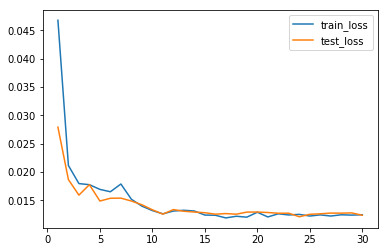

In [39]:
plt.plot(range(1, epochs+1), train_loss, label='train_loss')
plt.plot(range(1, epochs+1), test_loss, label='test_loss')
plt.legend()

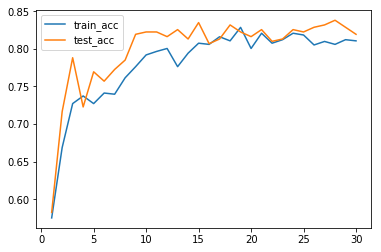

In [40]:
plt.plot(range(1, epochs+1), train_acc, label='train_acc')
plt.plot(range(1, epochs+1), test_acc, label='test_acc')
plt.legend()